# Connectome-constrained models with neural types

In this tutorial, we extend on the previous example, but now explicitly specify cell-type information for each neuron in our connectome. Cell-types by construction can share parameters such as synapse sign, time constants and nonlinearities.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

from bioplnn.models import ConnectomeODERNN

Check the device to make sure you are on a GPU. If you aren't its not a big deal. Its just going to take much longer!

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")
print("Using device: {}".format(device))

Using device: cuda


Download the connectome and read it in as a torch tensor. We have pre-processed this as a sparse tensor for the purposes of this example.
In addition to the connectome from before, we also have typing information preprocessed for you. Feel free to check its contents out.

In [4]:
save_dir = "connectivity/turaga"
os.makedirs(save_dir, exist_ok=True)
save_path = f"{save_dir}/turaga-dros-visual-connectome.pt"
!gdown "https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g" -O "{save_path}" 
connectome = torch.load(save_path, weights_only=True)

save_path_index_1 = f"{save_dir}/example_indices_ntype1.pt"
!gdown "https://drive.google.com/uc?id=19ePGRpMznn2l1Mp8Gu0rTk-PP-EDlyEC" -O "{save_path_index_1}" 
ex_indices_neuron_type1 = torch.load(save_path_index_1, weights_only=True)

save_path_index_2 = f"{save_dir}/example_indices_ntype2.pt"
!gdown "https://drive.google.com/uc?id=1eb0H-WTQWg1DzFZ201-ihIFqgZ8u3N0Y" -O "{save_path_index_2}" 
ex_indices_neuron_type2 = torch.load(save_path_index_2, weights_only=True)

Downloading...
From (original): https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g
From (redirected): https://drive.google.com/uc?id=18448HYpYrm60boziHG73bxN4CK5jG-1g&confirm=t&uuid=27f9b878-4dc9-4201-8ae8-83319e4db65d
To: /net/vast-storage/scratch/vast/mcdermott/lakshmin/hackathon-test/bioplnn/examples/connectivity/turaga/turaga-dros-visual-connectome.pt
100%|████████████████████████████████████████| 111M/111M [00:01<00:00, 89.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=19ePGRpMznn2l1Mp8Gu0rTk-PP-EDlyEC
To: /net/vast-storage/scratch/vast/mcdermott/lakshmin/hackathon-test/bioplnn/examples/connectivity/turaga/example_indices_ntype1.pt
100%|████████████████████████████████████████| 381k/381k [00:00<00:00, 17.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eb0H-WTQWg1DzFZ201-ihIFqgZ8u3N0Y
To: /net/vast-storage/scratch/vast/mcdermott/lakshmin/hackathon-test/bioplnn/examples/connectivity/turaga/example_indices_ntype2.pt
100%|█████████████████████████

Connectome dimensions: 47521x47521
Number of synapses: 4623254


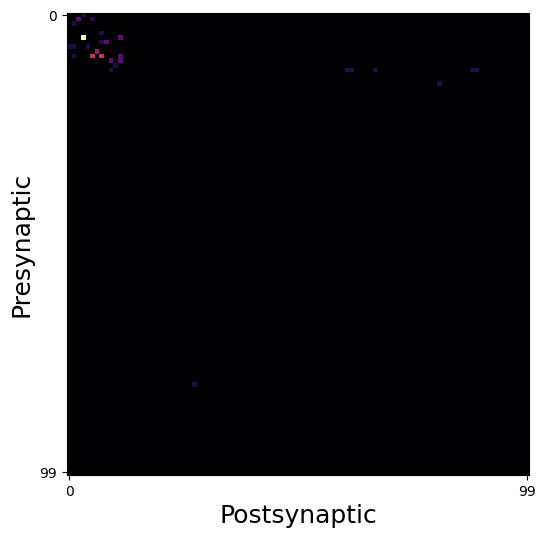

In [5]:
print(
    "Connectome dimensions: {}x{}".format(
        connectome.shape[0], connectome.shape[1]
    )
)
print("Number of synapses: {}".format(connectome._nnz()))

spatial_extent = 100
vmin, vmax = connectome.values().min(), connectome.values().max()
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(
    torch.abs(connectome.to_dense()[:spatial_extent, :spatial_extent]),
    cmap="inferno",
)
ax.set_xlabel("Postsynaptic", fontsize=18)
ax.set_ylabel("Presynaptic", fontsize=18)
ax.set_xticks([0, spatial_extent - 1])
ax.set_yticks([0, spatial_extent - 1])
plt.show()

## Creating input and output projection matrices
To drive the network with external inputs, you'd want to specify the subset of neurons in the model that receive input or project to downstream areas. We have an utility to create these sparse projection matrices. For the purposes of this example, we shall pick a random subset of input/output neurons. 
In a world where each neuron receives external input, you can also initialize this projection as an arbitrary *dense* matrix.

In [6]:
from bioplnn.utils.torch import create_identity_ih_connectivity

# since we are feeding in MNIST images
input_size = 28 * 28
num_neurons = connectome.shape[0]

input_projection_matrix = create_identity_ih_connectivity(
    input_size=input_size,
    num_neurons=num_neurons,
    input_indices=torch.randint(high=num_neurons, size=(input_size,)),
)

# for now, lets just read outputs from all neurons
output_projection_matrix = None

## Setting up the connectome-constrained model

In [7]:
connectome_rnn_kwargs = {
    "input_size": input_size,
    "hidden_size": num_neurons,
    "connectivity_hh": connectome,
    "connectivity_ih": input_projection_matrix,
    "output_neurons": output_projection_matrix,
    "num_neuron_types": 2,
    # this is new!
    "neuron_type_class": ["excitatory", "inhibitory"],
    "neuron_type_indices": [
        ex_indices_neuron_type1,
        ex_indices_neuron_type2,
    ],
    # note how the nonlinearity is global -- it can be per-celltype if needed
    # also note how the taus are initialized per neuron type.
    "neuron_type_nonlinearity": "Sigmoid",
    "neuron_type_tau_init": [1.25, 2.0],
    # flag to determine if these are tunable via gradients. same holds true for synaptic gains.
    "train_tau": True,
    "batch_first": False,
    "compile_solver_kwargs": {
        "mode": "max-autotune",
        "dynamic": False,
        "fullgraph": True,
    },
}
model = ConnectomeODERNN(**connectome_rnn_kwargs).to(device)
print(model)

ConnectomeODERNN(
  (nonlinearity): Sigmoid()
  (hh): SparseLinear()
  (ih): SparseLinear()
  (solver): OptimizedModule(
    (_orig_mod): AutoDiffAdjoint(step_method=Dopri5(
      (term): ODETerm()
    ), step_size_controller=IntegralController(
      (term): ODETerm()
    ), max_steps=None, backprop_through_step_size_control=True)
  )
  (neuron_type_indices): ParameterList(
      (0): Parameter containing: [torch.int64 of size 23760 (cuda:0)]
      (1): Parameter containing: [torch.int64 of size 23761 (cuda:0)]
  )
  (neuron_type_nonlinearity): ModuleList(
    (0-1): 2 x Sigmoid()
  )
)


In [8]:
# get some data for us to pipe into the model
transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])
train_data = MNIST(root="data", train=True, transform=transform, download=True)
train_loader = DataLoader(
    train_data, batch_size=8, num_workers=0, shuffle=True
)

In [9]:
# getting one batch of the input
x, label = next(iter(train_loader))
print(f"x shape: {x.shape}, label_shape: {label.shape}")
x = x.flatten(1)
x = x.to(device)
print(f"x flattened shape: {x.shape}")

x shape: torch.Size([8, 1, 28, 28]), label_shape: torch.Size([8])
x flattened shape: torch.Size([8, 784])


In [10]:
model.eval()
_, neural_activities, timesteps = model(
    x, start_time=0, end_time=1.0, num_steps=20
)
print(f"Neural activity shape: {neural_activities.shape}")

Neural activity shape: torch.Size([20, 8, 47521])


/scratch2/weka/mcdermott/lakshmin/conda_envs/test_bioplnn_env/lib/python3.12/site-packages/torch/_inductor/cudagraph_trees.py:2345: UserWarning: Unable to hit fast path of CUDAGraphs because of pending, uninvoked backwards. Consider running with torch.no_grad() or using torch.compiler.cudagraph_mark_step_begin() before each model invocation
  warnings.warn(


Text(0, 0.5, 'Activity')

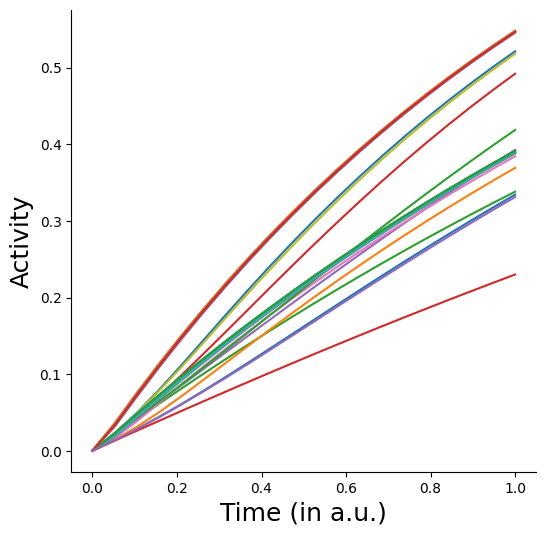

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(
    timesteps[:, 0].detach().cpu().numpy(),
    neural_activities[:, 0, torch.randint(0, 47521, (25,))]
    .detach()
    .cpu()
    .numpy(),
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Time (in a.u.)", fontsize=18)
ax.set_ylabel("Activity", fontsize=18)